In [1]:
# Libraries 

import requests
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from pandas import read_csv
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Loads part of PubChem hERG Channel assay data and segments it into 10 parts #

redex = read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS-8VEfUfIgDLPFh62hwfZRpiL6n7VYI3b_55PqWfU1X8vXUDIYQbQPHtdc4ulHEWlN9U73-wTwihMh/pub?output=csv')
redex['CID'] = redex['CID'].astype(int)
CID = redex['CID']
p1 = CID.iloc[0:200]
p2 = CID.iloc[200:400]
p3 = CID.iloc[400:600]
p4 = CID.iloc[600:800] 
p5 = CID.iloc[800:1000]
p6 = CID.iloc[1000:1200]
p7 = CID.iloc[1200:1400]
p8 = CID.iloc[1400:1600]
p9 = CID.iloc[1600:1800]
p10 = CID.iloc[1800:]
P = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]

# Compound Properties are taken from PubChem:
# MolecularWeight, TPSA, Complexity, Charge, HBondDonorCount, HBondAcceptorCount, RotatableBondCount, 
# AtomStereoCount, BondStereoCount, ExactMass

# List of descriptors used:
descriptors = ['MolecularWeight', 'TPSA', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 'AtomStereoCount', 'BondStereoCount', 'ExactMass']

In [2]:
# Creates a dataframe called "data" containing the descriptor values for all compounds in hERG assay #
# All data are taken from PubChem database using PUG REST #

hubcode = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/??/property/---/TXT'
data = pd.DataFrame({})
for k in descriptors:
    mcode = hubcode.replace('---', k)
    block = []
    for i in P:
        q = ''
        leng = np.linspace(i.index[0],i.index[-1],num= i.index[-1]-i.index[0]+1)
        for x in leng:
            q += ',' + str(i[int(x)])
        code = mcode.replace('??',q)
        g = requests.get(code)
        block.append(g.text.split())
    recent = []
    for j in block:
        recent += j
    recent1 = []
    for w in recent:
        recent1.append(float(w))
    data[k]=recent1 
data['Activity'] = redex['Activity']

In [3]:
# Data are split randomly into train and test sets, putting 20% of data in test set #

argon = data.values
x = argon[:,0:10]
y = argon[:,10]
X_train, X_test, Y_train, Y_test, = train_test_split(x,y,test_size = .2, random_state = 1)

# Six supervised machine learning models are used from sklearn:
# Logistic Regression 'LR'
# Linear Discrimination Analysis 'LDA'
# K-Nearest Neighbors Classifier 'KNC'
# Decision Tree Classifier 'DTC'
# Gaussian Naive Bayes 'Gaus'
# Support Vector Machines 'SVM'

models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('Gaus', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# Evaluates each model using the data #
# Outputs the cross-validated accuracy of each model #

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    print(name + ': Mean = ' + str(cv_results.mean()) + ' STD = (' + str(cv_results.std()) + ')')

LR: Mean = 0.8701290217213783 STD = (0.00895134373922646)
LDA: Mean = 0.8675771680548751 STD = (0.008841239051872342)
KNC: Mean = 0.8599011922260329 STD = (0.012397810718949734)
DTC: Mean = 0.7907806630736567 STD = (0.026163183958981092)
Gaus: Mean = 0.8310958680385431 STD = (0.02329432613718936)
SVM: Mean = 0.8758819206271437 STD = (0.004166204031548013)


In [4]:
# Enter PubChem CID of a compound to test the model #
# Outputs the activity reported for each model

hubcode = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/??/property/---/CSV'
q = ''
for i in descriptors:
    q += i + ','
pubcode = hubcode.replace('---',q)
id = input('Enter CID: ')
mcode = pubcode.replace('??', id)
g = read_csv(mcode)
tst = g.drop(columns = ['CID'])
for k,l in models:
    l.fit(x,y)
    print(k + ': ' + str(l.predict(tst))[2:-2])

Enter CID: 2244
LR: Inactive
LDA: Inactive
KNC: Inactive
DTC: Inactive
Gaus: Inactive
SVM: Inactive


Enter a Property: ExactMass


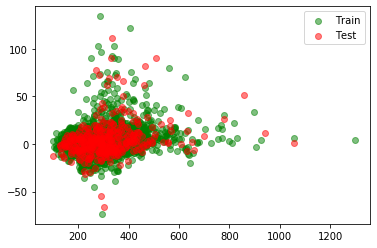

In [5]:
# MolecularWeight, TPSA, Complexity, Charge, HBondDonorCount, HBondAcceptorCount, RotatableBondCount, 
# AtomStereoCount, BondStereoCount, ExactMass
# Enter compound property from the list above to check correlation with the data
# Outputs graph of training and testing sets for a Linear Regression Model for the property
# Dependent variable: percent activity

percents = redex['Percent']
hubcode = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/??/property/---/TXT'
prop = input('Enter a Property: ')
mcode = hubcode.replace('---', prop)
block = []
for i in P:
    q = ''
    leng = np.linspace(i.index[0],i.index[-1],num= i.index[-1]-i.index[0]+1)
    for x in leng:
        q += ',' + str(i[int(x)])
    code = mcode.replace('??',q)
    g = requests.get(code)
    block.append(g.text.split())
recent = []
for j in block:
    recent += j
recent1 = []
for w in recent:
    recent1.append(float(w))

proptest = pd.DataFrame({'Property': recent1,
                        'Percent': percents})
x_train,x_test,y_train,y_test = train_test_split(proptest.Property, proptest.Percent, test_size = .2)
plt.scatter(x_train, y_train, label = 'Train', color = 'g', alpha = .5)
plt.scatter(x_test, y_test, label = 'Test', color = 'r', alpha = .5)
plt.legend()
plt.show()

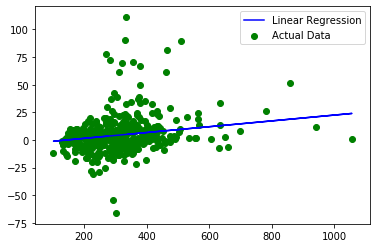

slope = 0.02632419091238964
R^2 = 0.05509697962646409


In [6]:
# Runs a Linear Regression model for the property
# Outputs graph of test data with linear regression, predicted slope, and coefficient of determination
# MolecularWeight appears to be the most correlated with activity

LR = LinearRegression()
LR.fit(x_train.values.reshape(-1,1), y_train.values)
prediction = LR.predict(x_test.values.reshape(-1,1))

plt.plot(x_test, prediction, label='Linear Regression', color='b')
plt.scatter(x_test,y_test, label='Actual Data', color = 'g')
plt.legend()
plt.show()
m = LR.coef_[0]
r2 = r2_score(y_test,prediction)
print('slope = ' + str(m))
print('R^2 = ' + str(r2))